In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5


In [3]:
f(3.0)

20.0

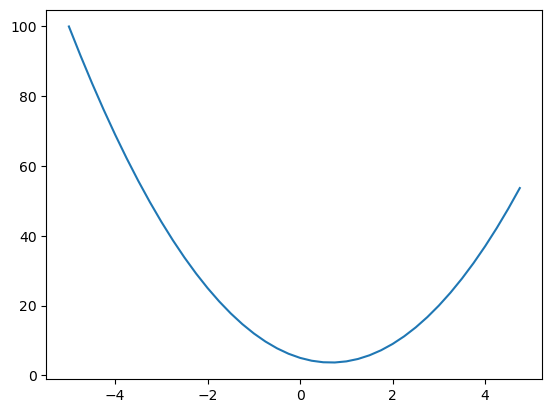

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000001
x = -3.0
(f(x + h) - f(x))/h

-21.999999688659955

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)


4.0


In [7]:
# get derivative of d wrt a b and c

In [8]:
# les get more complex
h1 = 0.001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c
print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"slope: {(d2 - d1)/h}")

d1: 4.0
d2: 3.9999997
slope: -2.9999999995311555


In [9]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-1 * other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value(data=-8.0)

In [10]:
a = Value(2.0)
b = Value(3.0)
a - b

Value(data=-1.0)

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad: %.4f  }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


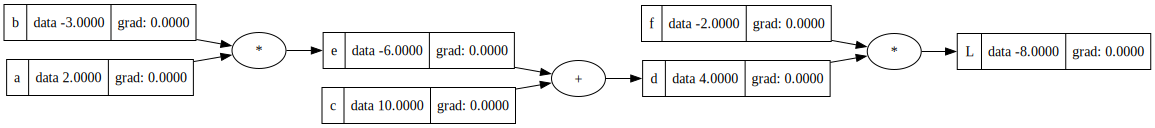

In [12]:
draw_dot(L)

In [13]:
# forward pass

step_size = 0.01
a.data += step_size * a.grad 
b.data += step_size * b.grad 
c.data += step_size * c.grad 
f.data += step_size * f.grad 

e = a * b
d = e + c
L = d * f

print(L.data)


-32.0


In [14]:
"""
Chain Rule:
dz/dx = dz/dy * dy/dx
how to chain these derivatives together

dL/dc = dL/dd * dd/dc = -2 * 1 = -2
"""

'\nChain Rule:\ndz/dx = dz/dy * dy/dx\nhow to chain these derivatives together\n\ndL/dc = dL/dd * dd/dc = -2 * 1 = -2\n'

In [15]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1) / h)
    
lol()

-3.9999999999995595


In [16]:
"""
What are we doing when we calculate the gradient of L with respect to a variable x?
-> we are seeing how loss changes with respect to a tiny change to the variable x
-> "Gradient check" - deriving derivative and then estimating with small step size
"""

'\nWhat are we doing when we calculate the gradient of L with respect to a variable x?\n-> we are seeing how loss changes with respect to a tiny change to the variable x\n-> "Gradient check" - deriving derivative and then estimating with small step size\n'

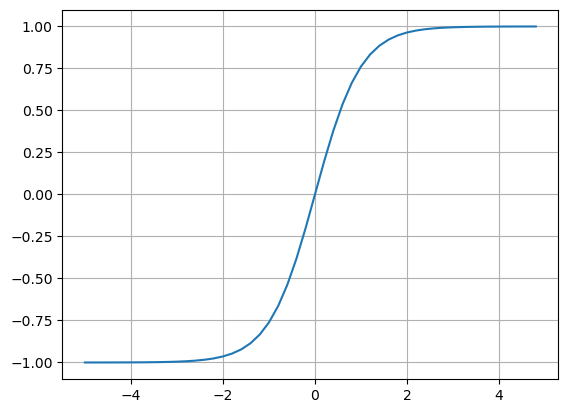

In [17]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();


In [18]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

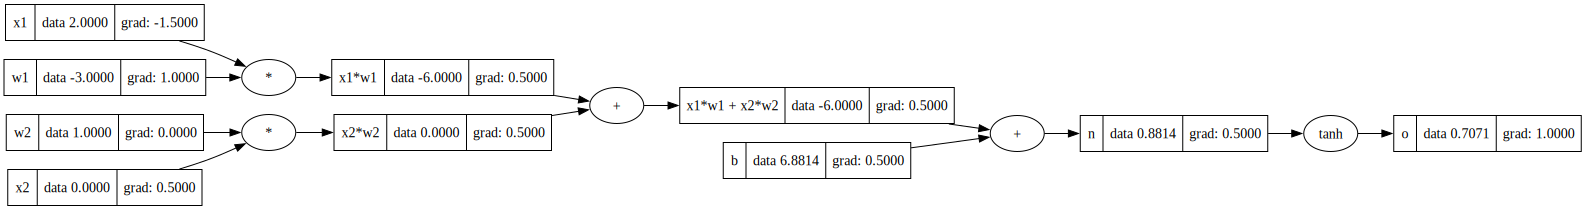

In [19]:
draw_dot(o)

In [20]:
# o.backward()

In [21]:
o.grad = 1.0

topo = []
def build_topo(v):
    for c in v._prev:
        build_topo(c)
    topo.append(v)
build_topo(o)

for v in reversed(topo):
    v._backward()

In [22]:
topo = []
def build_topo(v):
    for c in v._prev:
        build_topo(c)
    topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [23]:
o.grad = 1.0


In [24]:
o._backward()


In [25]:
n._backward()

In [26]:
b._backward()

In [27]:
x1w1x2w2._backward()

In [28]:
x1w1._backward()
x2w2._backward()

In [29]:
o.grad = 1.0
# o = tanh(h); do / dn = 1 - o**2
n.grad = 1 - o.data ** 2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

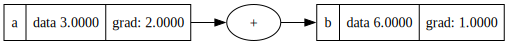

In [30]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


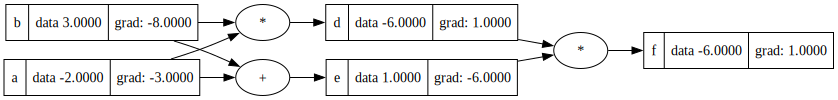

In [31]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)


In [32]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
##########
e = (2*n).exp()
o = (e - 1) / (e + 1);  o.label = 'o'
# o = n.tanh(); o.label = 'o'
##########
o.backward()

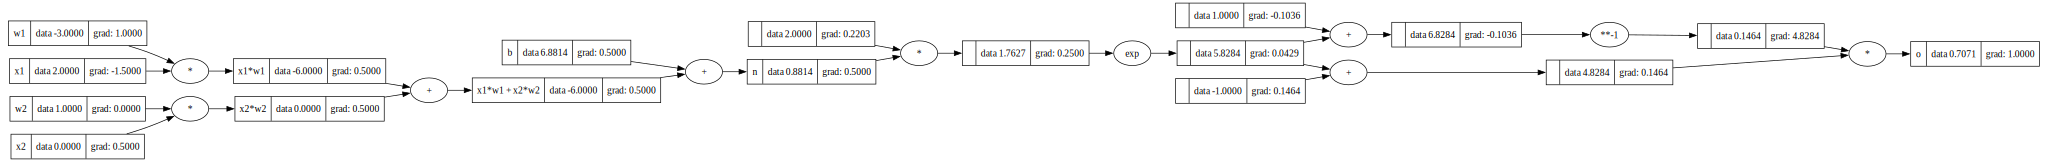

In [33]:
draw_dot(o)

In [34]:
!pip install torch


^C


In [35]:
"""

PYTORCH!

"""

'\n\nPYTORCH!\n\n'

In [36]:
import torch
import random

DEPRECATION: Loading egg at c:\users\03123\anaconda3\lib\site-packages\dataclasses_json-0.6.6-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\03123\anaconda3\lib\site-packages\httpx-0.27.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\03123\anaconda3\lib\site-packages\langchain-0.2.0rc2-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\03123\anaconda3\lib\site-packages\langchain_core-0.1.52-py3.11.egg is deprecated. pip 25.

In [37]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [38]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out


  def parameters(self):
      return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
      
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9358925752039376)

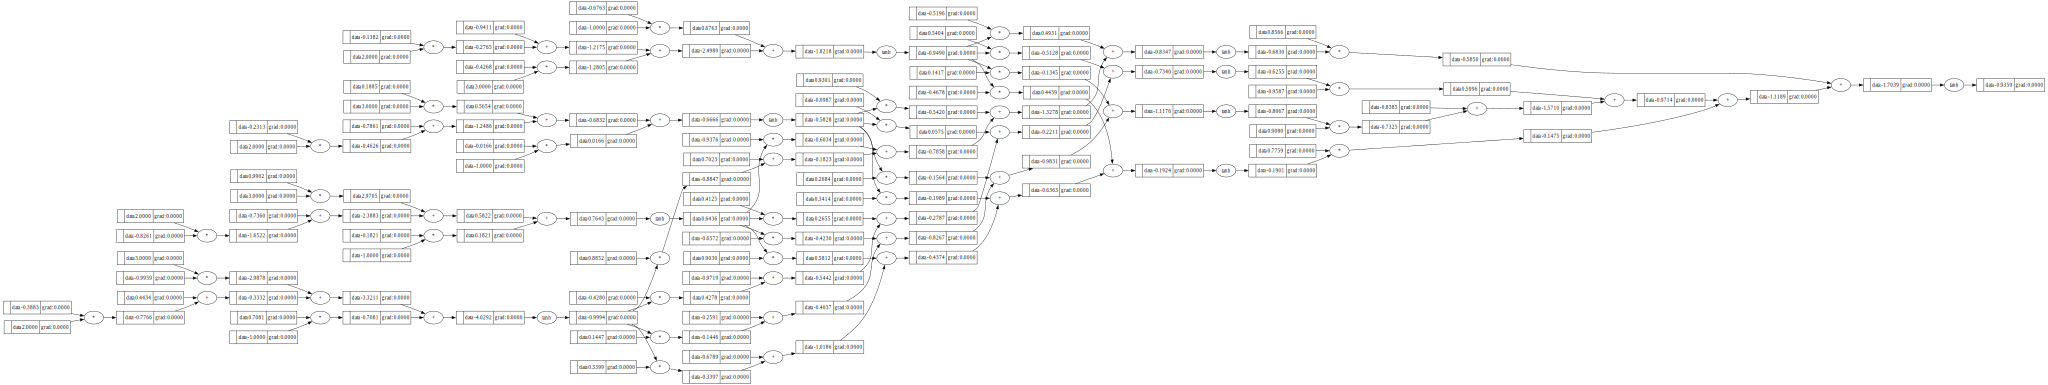

In [39]:
draw_dot(n(x))

In [40]:
# dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [41]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=9.484760680293466)

In [42]:
loss.backward()

In [43]:
for p in n.parameters():
    p.data += -0.1 * p.grad # 0.01 is called "learning rate"

In [44]:
ypred

[Value(data=-0.9358925752039376),
 Value(data=0.30356837078958787),
 Value(data=-0.14639321544577336),
 Value(data=-0.819105708199418)]

In [45]:
n.layers[0].neurons[0].w[0].data

-0.585511757478326

In [46]:
n.parameters()

[Value(data=-0.585511757478326),
 Value(data=-1.0438503663823409),
 Value(data=0.545354437027797),
 Value(data=0.2911691180219881),
 Value(data=-0.9254314877489183),
 Value(data=0.9267567485678593),
 Value(data=0.03775635863225038),
 Value(data=-0.7878667078997735),
 Value(data=-0.18371528440820115),
 Value(data=0.2734462736416348),
 Value(data=-0.20179497811226615),
 Value(data=-0.7788478877428883),
 Value(data=-0.1752698369299138),
 Value(data=-0.48057594687107463),
 Value(data=-0.6248638823392532),
 Value(data=-0.9793537909852562),
 Value(data=-0.06834340882923132),
 Value(data=-0.4248245087651584),
 Value(data=0.4800978330609803),
 Value(data=0.3768019550098982),
 Value(data=-0.49932777625236185),
 Value(data=-0.34913701385094104),
 Value(data=0.38667414723311067),
 Value(data=-0.08296063283268848),
 Value(data=0.5590002133210167),
 Value(data=-1.0035571842749957),
 Value(data=0.2565976145272681),
 Value(data=0.9881394806695413),
 Value(data=0.39424057055053),
 Value(data=-0.404940

In [47]:
# more respectable training loop

In [48]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4298576144084045)

In [49]:
# dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
  [3.0, 9.0, 7.0]
]
ys = [-1.0, 1.0, -1.0, 1.0, 1.0] # desired targets

In [50]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.4298576144084045),
 Value(data=0.7261583140402115),
 Value(data=0.9345636983884406),
 Value(data=-0.4517895036608398),
 Value(data=0.9139111079008603)]

In [51]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.9771228298559995)

In [52]:
for k in range(200):
    # forward pass
    ypred = [n(x) for x in xs]
    
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # "zero-grad"
    for p in n.parameters():
        p.grad = 0.0
    
    #backward pass
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad # 0.05 is called "learning rate"

    print(k, loss.data)
    

0 7.9771228298559995
1 5.9888998188204265
2 5.580189802221308
3 5.2921466052435715
4 4.931172997278593
5 4.377667352558415
6 3.7357617454495022
7 3.3785219168953917
8 3.167613240625663
9 3.0062876674919563
10 2.8585635115811114
11 2.7062002751509713
12 2.5309942487307717
13 2.314866059115679
14 2.053656321212661
15 1.7729779035428817
16 1.5107777727771214
17 1.2888210766993387
18 1.1092148893132028
19 0.964964269388019
20 0.8480396202334909
21 0.7520077075142239
22 0.6721478411334997
23 0.605015854681754
24 0.5480519798213344
25 0.4993128586709157
26 0.4572961123100597
27 0.4208234465038314
28 0.3889600178183352
29 0.3609569505127196
30 0.3362092758201619
31 0.3142245488343909
32 0.29459908735315665
33 0.27699977590227315
34 0.2611500012743664
35 0.24681869398495865
36 0.2338117279846378
37 0.2219651259173167
38 0.21113965691179729
39 0.2012165155712582
40 0.1920938457052441
41 0.1836839280086029
42 0.17591089258712245
43 0.16870884867703817
44 0.16202034777140895
45 0.1557951145840645

In [53]:
ypred

[Value(data=-0.9449173273954495),
 Value(data=0.9918931324804381),
 Value(data=-0.9285516243623214),
 Value(data=0.9273341373045709),
 Value(data=0.926066084691226)]